In [4]:
import pandas as pd
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_pickle('/content/drive/My Drive/Northwestern MS/453 - Natural Language Processing/imdb/imdb_dataset.pkl')
df.head()

,review,sentiment,processed
0,One of the other reviewers has mentioned that ...,positive,"[[reviewer, mention, watch, oz, episode, hook,..."
1,A wonderful little production. <br /><br />The...,positive,"[[wonderful, little, production, filming, tech..."
2,I thought this was a wonderful way to spend ti...,positive,"[[think, wonderful, way, spend, time, hot, sum..."
3,Basically there's a family where a little boy ...,negative,"[[basically, family, little, boy, jake, think,..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[[petter, matteis, love, time, money, visually..."


In [7]:
# Combine the processed tokens back into strings for Doc2Vec
df['processed_text'] = df['processed'].apply(lambda x: ' '.join([' '.join(tokens) for tokens in x]))

In [8]:
# Tokenize the processed text
tokenized_texts = df['processed'].tolist()
tokenized_texts = [text for text in tokenized_texts if text]  # Remove empty lists

# Flatten the tokenized texts
flattened_texts = [word for sublist in tokenized_texts for word in sublist]

# Create bigrams and trigrams using Phrases
bigram = Phrases(flattened_texts, min_count=5, threshold=100)
trigram = Phrases(bigram[flattened_texts], threshold=100)

bigram_phraser = Phraser(bigram)
trigram_phraser = Phraser(trigram)

# Apply bigrams and trigrams to the tokenized texts
texts_with_ngrams = [trigram_phraser[bigram_phraser[text]] for text in tokenized_texts]

In [9]:
# Prepare data for Doc2Vec
documents = []
for i, text in enumerate(texts_with_ngrams):
    # Flatten any nested lists within text
    if any(isinstance(i, list) for i in text):
        text = [item for sublist in text for item in sublist]
    documents.append(TaggedDocument(words=text, tags=[str(i)]))

# Ensure that each element in documents is a TaggedDocument and words are lists of strings
for doc in documents:
    assert isinstance(doc, TaggedDocument), f"Expected TaggedDocument, got {type(doc)}"
    assert all(isinstance(word, str) for word in doc.words), "Each word should be a string"

# Train a Doc2Vec model
doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=2, workers=4, epochs=40)
doc2vec_model.build_vocab(documents)
doc2vec_model.train(documents, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

In [10]:
# Get document vectors
doc_vectors = [doc2vec_model.dv[str(i)] for i in range(len(documents))]

In [11]:
# Get embeddings for each document
embeddings = [doc2vec_model.infer_vector(doc.words) for doc in documents]

# Convert embeddings to DataFrame for clustering
embeddings_df = pd.DataFrame(embeddings)

In [12]:
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.501618,0.164232,-0.687424,0.456446,-0.894968,-2.257915,0.228125,1.964802,-0.481894,0.662188,...,2.392052,0.079842,2.045716,-1.270257,1.064509,1.723800,0.628179,-0.688859,-1.628123,-1.355341
1,-0.365358,2.384981,-0.279481,0.352401,-0.470002,0.050526,-0.866197,-0.412319,0.651297,-2.049760,...,0.767018,1.968958,-0.728388,-0.284288,0.689161,1.379422,0.503419,-1.220167,-1.444172,0.647671
2,0.946937,1.573278,-1.519988,0.782868,0.184616,-0.853950,0.537544,0.863877,-0.742539,-0.402138,...,0.788282,-1.107653,0.709821,1.976070,-0.354313,1.319767,1.775188,1.175694,-1.982500,0.457960
3,0.537245,-0.687223,-1.167942,0.429164,0.213441,-1.387397,-0.745562,-0.722211,-0.085279,-0.222465,...,2.237369,-2.202821,0.442173,1.106392,-0.997359,0.794328,-0.201841,-0.040549,1.549424,-1.393315
4,0.502567,0.749984,-1.455203,-1.174098,0.804368,-2.091628,-1.033265,-0.807077,-0.011158,-1.278914,...,0.177937,-0.942314,0.043687,-1.070671,1.851442,1.642835,-2.512048,2.696857,-0.109828,-0.837788


In [13]:
pd.to_pickle(embeddings_df, '/content/drive/My Drive/Northwestern MS/453 - Natural Language Processing/imdb/embeddings_df.pkl')

In [14]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10000, metric='cosine')
dbscan_labels = dbscan.fit_predict(embeddings_df)

# Add DBSCAN labels to the original DataFrame
df['dbscan_cluster'] = dbscan_labels

In [ ]:
# Perform Hierarchical Clustering
linkage_matrix = linkage(embeddings_df, method='ward')

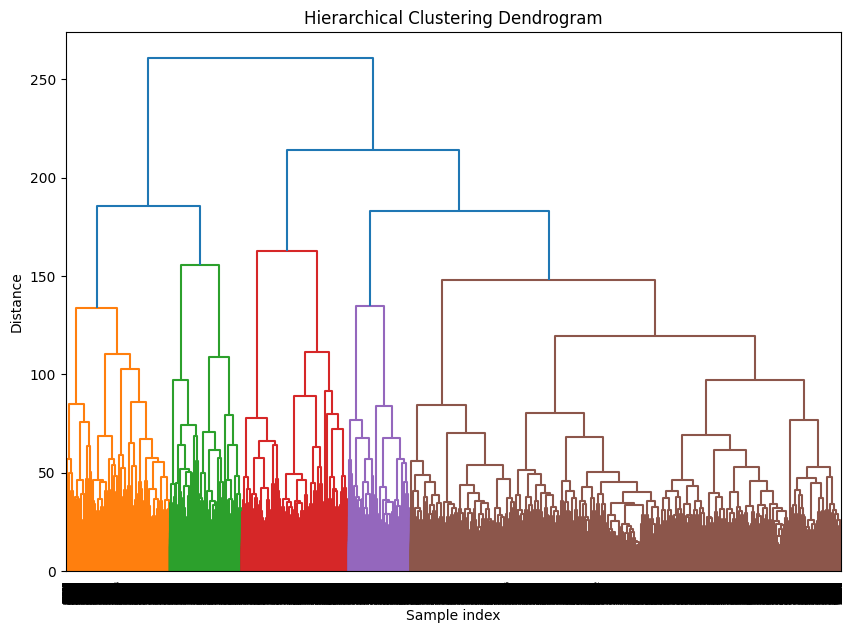

In [22]:
# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [ ]:
# Assign clusters from hierarchical clustering
hierarchical_labels = fcluster(linkage_matrix, t=5, criterion='maxclust')

# Add Hierarchical Clustering labels to the original DataFrame
df['hierarchical_cluster'] = hierarchical_labels

In [27]:
# Check the unique labels in the 'dbscan_cluster' column
unique_labels = df['dbscan_cluster'].unique()

# Print the unique labels
print(f"Unique labels in 'dbscan_cluster': {unique_labels}")

# If there is only one unique label, skip calculating the silhouette score for DBSCAN
if len(unique_labels) <= 1:
    print("DBSCAN did not find any clusters. Skipping silhouette score calculation.")
else:
    # Calculate silhouette score for DBSCAN
    dbscan_silhouette = silhouette_score(embeddings_df, df['dbscan_cluster'])
    print(f"Silhouette score for 'dbscan_cluster': {dbscan_silhouette}")

# Calculate silhouette score for hierarchical clustering
hierarchical_silhouette = silhouette_score(embeddings_df, df['hierarchical_cluster'])
print(f"Silhouette score for 'hierarchical_cluster': {hierarchical_silhouette}")

Unique labels in 'dbscan_cluster': [-1]
DBSCAN did not find any clusters. Skipping silhouette score calculation.
Silhouette score for 'hierarchical_cluster': 0.025250058621168137


In [16]:
# Display the DataFrame with clustering labels
df[['review', 'sentiment', 'dbscan_cluster', 'hierarchical_cluster']].head(10)


,review,sentiment,dbscan_cluster,hierarchical_cluster
0,One of the other reviewers has mentioned that ...,positive,-1,2
1,A wonderful little production. <br /><br />The...,positive,-1,2
2,I thought this was a wonderful way to spend ti...,positive,-1,5
3,Basically there's a family where a little boy ...,negative,-1,5
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,-1,1
5,"Probably my all-time favorite movie, a story o...",positive,-1,5
6,I sure would like to see a resurrection of a u...,positive,-1,3
7,"This show was an amazing, fresh & innovative i...",negative,-1,4
8,Encouraged by the positive comments about this...,negative,-1,5
9,If you like original gut wrenching laughter yo...,positive,-1,5


In [ ]:
# Reduce dimensionality of the embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_df)

# Create a DataFrame for the 2D embeddings and cluster labels
embeddings_2d_df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
embeddings_2d_df['dbscan_cluster'] = dbscan_labels
embeddings_2d_df['hierarchical_cluster'] = hierarchical_labels


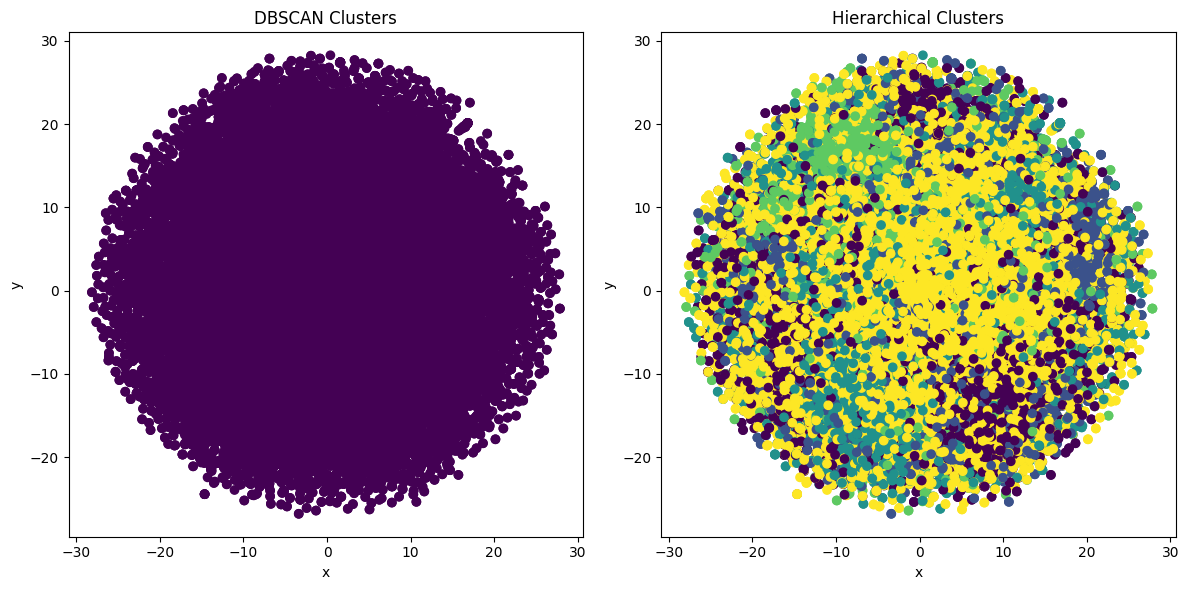

In [21]:
# Plot DBSCAN Clusters
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(embeddings_2d_df['x'], embeddings_2d_df['y'], c=embeddings_2d_df['dbscan_cluster'], cmap='viridis', marker='o')
plt.title('DBSCAN Clusters')
plt.xlabel('x')
plt.ylabel('y')

# Plot Hierarchical Clusters
plt.subplot(1, 2, 2)
plt.scatter(embeddings_2d_df['x'], embeddings_2d_df['y'], c=embeddings_2d_df['hierarchical_cluster'], cmap='viridis', marker='o')
plt.title('Hierarchical Clusters')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()

In [18]:
# Create cross-tabulation of DBSCAN clusters with sentiment
dbscan_crosstab = pd.crosstab(df['dbscan_cluster'], df['sentiment'], margins=True)
print("DBSCAN Clusters with Sentiment Cross-Tabulation")
print(dbscan_crosstab)

DBSCAN Clusters with Sentiment Cross-Tabulation
sentiment       negative  positive    All
dbscan_cluster                           
-1                 25000     25000  50000
All                25000     25000  50000


In [20]:
# Create cross-tabulation of Hierarchical clusters with sentiment
hierarchical_crosstab = pd.crosstab(df['hierarchical_cluster'], df['sentiment'], margins=True)
print("\nHierarchical Clusters with Sentiment Cross-Tabulation")
print(hierarchical_crosstab)


Hierarchical Clusters with Sentiment Cross-Tabulation
sentiment             negative  positive    All
hierarchical_cluster                           
1                         2488      4259   6747
2                         1630      2990   4620
3                         4654      2229   6883
4                         1660      2356   4016
5                        14568     13166  27734
All                      25000     25000  50000
